In [24]:
import numpy as np 
import math 
import matplotlib.pyplot as plt
from itertools import combinations, product
from scipy.spatial.transform import Rotation as R
import scipy.interpolate
import pickle
from mpl_toolkits.mplot3d import Axes3D
import concurrent.futures

In [26]:
def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

c_001 = np.array([0,0,1])
c_target = np.array([1,1,1])

c_cross = np.cross(c_001, c_target)
c_cross = c_cross/np.linalg.norm(c_cross)
c_angle = np.arccos(np.dot(c_001, c_target)/(np.linalg.norm(c_001)*np.linalg.norm(c_target)))

r = R.from_rotvec(c_cross*c_angle)

fcc_001_matrix = 1/2*np.array([
    [0,1,1],
    [1,0,1],
    [1,1,0],
])

fcc_matrix = r.apply(fcc_001_matrix)

#* Define the fraction coordinates.
cart_, cart_pbc = [], []
#* Define x, y, z axis's range.
num_primcell = 4
i_list, j_list = np.arange(num_primcell), np.arange(num_primcell)
k_list = np.arange(num_primcell)

for i, j, k in product(i_list, j_list, k_list):
    frac_ = np.array([[i,j,k]])
    cart__ = np.dot(frac_, fcc_matrix)[0]
    cart_.append(cart__)
    
cart_ = np.array(cart_)

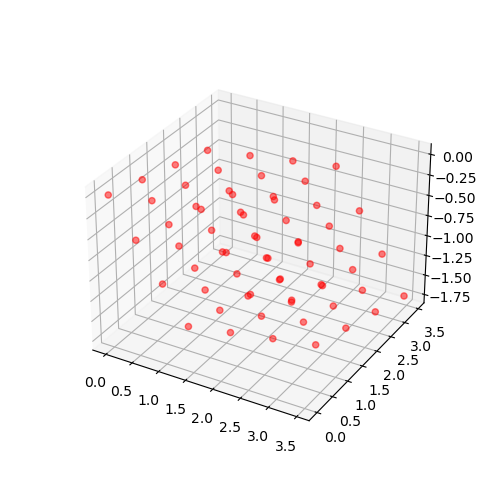

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [19]:
%matplotlib widget 

draw_3d(cart_)

Define the slip vector, we choosen a common slip system.

In [14]:
fcc_matrix

array([[ 1.83012702e-01,  6.83012702e-01,  1.66533454e-16],
       [ 6.83012702e-01,  1.83012702e-01,  1.66533454e-16],
       [ 2.88675135e-01,  2.88675135e-01, -5.77350269e-01]])

##### 重なり体積in fcc

Define $4^{th}, 5^{th}, 6^{th}$ layer as slip plane in slab model.

In this simple demonstration, use $4^{th}$ layer for volume accounting. ($S_3 + 1/N\sum_{dx}^N S_4$) 

Volume per each grid within one atom will be $2(dx)^2\sqrt{r^2-(mdx)^2}$ by approximation.

PBC condition will be implemented during slip as $R_{PBC}=abs[(R_c+m\vec{v})A^{-1}-R_f]A$

In [16]:
slip_vector_001 = np.array([1,-2,1])
slip_vector_ = r.apply(slip_vector_001)
slip_vector_

array([ 1.78867513, -1.21132487,  1.15470054])

In [27]:
slip_vector_001 = np.array([1,-1,0])
slip_vector_ = r.apply(slip_vector_001)

au_radii = 1.28 #* Angstrom
lp_au = 2*math.sqrt(2)*au_radii #* Angstrom
cart_cartesian = cart_*lp_au #* Cartesian coordinates for slab model
lp_supercell_001 = lp_au*num_primcell #* Lattice parameter (R_f) of supercell in [001] zone axis.
cell_fcc = np.array([lp_supercell_001, lp_supercell_001, lp_supercell_001]) #* FCC unit cell

ds_norm = au_radii/(20*math.sqrt(6)) #* Step per slip
grid_square = ds_norm**2 #* Grid square

slip_vector_norm = slip_vector_/np.linalg.norm(slip_vector_)
ds_ = ds_norm*slip_vector_norm #* Step vector
burgers_vector = lp_au/math.sqrt(2)
ds_num = int(np.ceil(burgers_vector*num_primcell/ds_norm))

z_coords = np.unique(np.round(cart_cartesian[:,2], 4))
target_layer_bot = np.where(np.abs(cart_cartesian[:,2]-z_coords[1]) < 0.001)[0] #* Static plane
target_layer_top = np.where(np.abs(cart_cartesian[:,2]-z_coords[2]) < 0.001)[0] #* Slip plane

cart_bot, cart_target = cart_cartesian[target_layer_bot], cart_cartesian[target_layer_top]

#* Define x_min, x_max, y_min, y_max
x_min, x_max = np.min(cart_target[:,0]), np.max(cart_target[:,0])
y_min, y_max = np.min(cart_target[:,1]), np.max(cart_target[:,1])

#* Seperate plane into grids by defining [x_min, x_max] and [y_min, y_max]
dN = int(np.ceil((np.linalg.norm([y_max-y_min, x_max-x_min]))/ds_norm))
dict_grid = {}
for i, j in product(range(dN), repeat=2):
    dN_x = x_min + i*ds_norm
    dN_y = y_min + j*ds_norm
    dN_x_ = x_min + (i+1)*ds_norm
    dN_y_ = y_min + (j+1)*ds_norm
    dict_grid[dN_x, dN_x_, dN_y, dN_y_] = 0
    
#* Create an empty list to store the volume of each 'grid' during slip.
V_total_image = {}

#* Return the valid index surround the target atom.
num_dx_atom = int(np.ceil(au_radii/ds_norm))
valid_surround_ind = []
for j, k in product(range(-num_dx_atom, num_dx_atom), repeat=2):
    atom_surround_relative = np.array([j*ds_norm, k*ds_norm, 0])
    if np.linalg.norm(atom_surround_relative) < au_radii:
        valid_surround_ind.append([j,k])
        
#* Get x, y list of grid.
dict_grid_keys = list(dict_grid.keys())
x_list, y_list = [], []

for i in range(len(dict_grid_keys)):
    x_min_, x_max_, y_min_, y_max_ = dict_grid_keys[i]
    x_list.append([x_min_, x_max_])
    y_list.append([y_min_, y_max_])
    
x_list = np.unique(np.array(x_list).flatten())
y_list = np.unique(np.array(y_list).flatten())

#* New dict mapping [ind_x, ind_y] -> {key} for key in dict_grid.
dict_grid_ind = {}
for i, j in product(range(len(x_list)-1), repeat=2):
    dict_grid_ind[i, j] = (x_list[i], x_list[i+1], y_list[j], y_list[j+1])

In [ ]:
def pbc_calib(image, fcc_matrix):
    cell_001 = image@np.linalg.inv(fcc_matrix)

    #* Calibration of out-PBC atoms.
    out_pbc_ind = np.where((cell_001 < 0) | (cell_001 > lp_supercell_001))
    cell_001[out_pbc_ind] = cell_001[out_pbc_ind] % lp_supercell_001

    cell_calib_image = cell_001@fcc_matrix
    
    return cell_calib_image

#* Calculate volume of each image.
def volume_image(cart_image, dict_grid):
    
    for i in range(len(cart_image)):
        atom_ = cart_image[i]
        x_list_min, x_list_max, y_list_min, y_list_max = x_list[0], x_list[-1], y_list[0], y_list[-1]
        for surround_grid in valid_surround_ind:
            surround_vector = np.array([surround_grid[0]*ds_norm, surround_grid[1]*ds_norm, 0])
            atom_surround = atom_ + surround_vector
            v_grid = grid_square*2*math.sqrt(au_radii**2-np.linalg.norm(surround_vector)**2)
            x_surround, y_surround = atom_surround[0], atom_surround[1]
            
            if (x_list_min <= x_surround <= x_list_max 
                and y_list_min <= y_surround <= y_list_max):
                
                x_gridind = np.where((x_list-x_surround) <= 0)[0][-1]
                y_gridind = np.where((y_list-y_surround) <= 0)[0][-1]
                correspond_dict_grid_ind = dict_grid_ind[x_gridind, y_gridind]
            
                dict_grid[correspond_dict_grid_ind] += v_grid
            # super_grid[key_surround] = super_grid.get(key_surround, 0) + v_grid
            
    return dict_grid

dict_grid_raw = dict_grid.copy()
dict_grid_raw = volume_image(cart_bot, dict_grid_raw)

for ds_i in range(ds_num):
    cart_target_ = cart_target.copy()
    cart_image = cart_target_ + ds_i*ds_
    #* Calibration of cell by PBC.
    cart_image = pbc_calib(cart_image, fcc_matrix)
    dict_grid = volume_image(cart_image, dict_grid)

#* Multiprocessing for image per step.
# def main(ds_i):
#     dict_grid_ = dict_grid.copy()
#     cart_target_ = cart_target.copy()
#     cart_image = cart_target_ + ds_i*ds_
#     #* Calibration of cell by PBC.
#     cart_image = pbc_calib(cart_image, fcc_matrix)
#     dict_grid_ = volume_image(cart_image, dict_grid_)
    
#     if ds_i % 50 == 0:
#         print(f'{ds_i} finished.')
    
#     return dict_grid_

# max_work = 8
# with concurrent.futures.ProcessPoolExecutor(max_workers=max_work) as executor:
#     dict_grid_images = executor.map(main, range(ds_num))

In [20]:
dict_grid_key = dict_grid.keys()
dict_grid_fin, dict_grid_raw_fin = {}, {}
for key in list(dict_grid_key):
    key_x = np.sum(key[:2])/2
    key_y = np.sum(key[2:])/2
    
    dict_grid_fin[key_x, key_y] = dict_grid[key]
    dict_grid_raw_fin[key_x, key_y] = dict_grid_raw[key]

In [21]:
with open('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/projLITE/crystal_overlap/utils/dict_grid_fin.pickle', 'wb') as f:
    pickle.dump(dict_grid_fin, f)
with open('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/projLITE/crystal_overlap/utils/dict_grid_raw.pickle', 'wb') as f:
    pickle.dump(dict_grid_raw_fin, f)

In [22]:
with open('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/projLITE/crystal_overlap/utils/dict_grid_fin.pickle', 'rb') as f:
    dict_grid_fin = pickle.load(f)
with open('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/projLITE/crystal_overlap/utils/dict_grid_raw.pickle', 'rb') as f:
    dict_grid_raw_fin = pickle.load(f)

In [69]:

x_list, y_list, volume_list = [], [], []
for key, value in dict_grid_fin.items():
    x_list.append(key[0])
    y_list.append(key[1])
    volume_list.append(value/ds_num+dict_grid_raw_fin[key])

# xi, yi = np.meshgrid(x_list, y_list)

# # Interpolate
# grid_volume = scipy.interpolate.griddata(np.array([x_list, y_list]).T, volume_list, 
#                         (xi, yi), method='linear')

# plt.imshow(grid_volume, vmin=volume_list.min(), vmax=volume_list.max(), origin='lower',
#            extent=[x_list.min(), x_list.max(), y_list.min(), y_list.max()])
# # plt.scatter(x, y, c=z)
# plt.colorbar()
# plt.show()

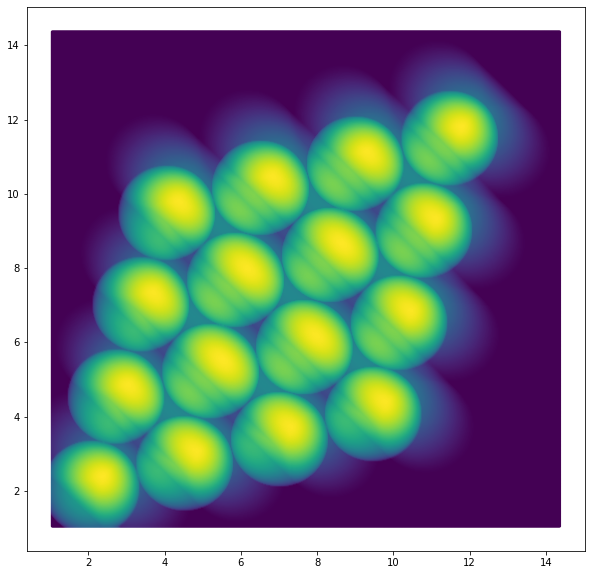

In [23]:
x_list, y_list, volume_list = [], [], []
for key, value in dict_grid_fin.items():
    x_list.append(key[0])
    y_list.append(key[1])
    volume_list.append(value/ds_num+dict_grid_raw_fin[key])

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x_list, y_list, c=volume_list, s=4, zorder=9)